# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Mentoría 16 - ¿Cómo identificar fuga de ventas? Inteligencia artificial aplicada al sector comercial.

### Explorando Patrones de Datos a través de Clustering (TP3)

#### Parte 4: Evaluación de resultados.

**Integrantes:**
- Canalis, Patricio.
- Chevallier-Boutell, Ignacio José.
- Villarroel Torrez, Daniel.

**Mentores:**
- Gonzalez, Lucía
- Lahoz, Nahuel

---
## Librerías

In [143]:
# Visualización y curación
import pandas as pd
import numpy as np
import seaborn as sns

# Clustering
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances

# Funciones propias
from tp3_utils_cluster import *
%load_ext autoreload
%autoreload 2

# Preferencias
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows',150)
sns.set_context('talk')
sns.set_theme(style='white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
# Datasets

## Carga

Los datasets que necesitamos son:
* `original` >> dataset curado, previo al cálculo de variaciones porcentuales (punto 15). Cada renglón representa ventas para un mes, ID y Subrubro en particular.
* `pivoteado` >> dataset pivoteado completo. Cada renglón representa vendedores (combinaciones de ID y Subrubro).
* `sr10` >> dataset pivoteado con los 10 subrubros que quedaron, luego de imputar con KNN y hacer PCA de 12 componentes.
* `outliers` >> información sobre los outliers encontrados en cada subrubro mediante DBSCAN.

### `original`

De aquí vamos a obtener para cada vendedor:
* El promedio de ventas
* El promedio de comisiones
* La cantidad de meses en los cuales tiene datos faltantes

In [144]:
original = pd.read_csv('../data/interim/tp3_registros_vendedores_abs.csv').drop(columns=['Omega', 'Modelo']).copy()
original

Subrubro    ID       Fecha       Ventas    Comision  Dato_original
0        Com. Varios     5  2019-01-01         0.00        0.00              0
1        Com. Varios    19  2019-01-01         0.00        0.00              0
2        Com. Varios    22  2019-01-01         0.00        0.00              0
3        Com. Varios    33  2019-01-01         0.00        0.00              0
4        Com. Varios    41  2019-01-01         0.00        0.00              1
...              ...   ...         ...          ...         ...            ...
193615  Venta Agrop.  3023  2022-06-01   3689910.44   110697.31              1
193616  Venta Agrop.  3041  2022-06-01  61730286.02  1851908.58              1
193617  Venta Agrop.  3056  2022-06-01   4279280.00   106982.00              1
193618  Venta Agrop.  3065  2022-06-01    822098.02    20552.45              1
193619  Venta Agrop.  3115  2022-06-01         0.00        0.00              1

[193620 rows x 6 columns]

In [145]:
original = original.groupby(['ID', 'Subrubro']).agg({'Ventas': 'mean', 'Comision': 'mean', 'Dato_original': 'sum'}).reset_index()
original['Faltantes'] = 42 - original['Dato_original']
original = original.drop(columns='Dato_original')
original = original.rename(columns={'Ventas': 'Abs_ven_mean', 'Comision': 'Abs_com_mean'})
original

ID     Subrubro  Abs_ven_mean   Abs_com_mean  Faltantes
0        0   Miscelaneo  3.763450e+06  121799.704086          0
1        1   Miscelaneo  2.160555e+07  957021.242103          0
2        2   Miscelaneo  7.596405e+06  345909.071399          0
3        4      Gondola  1.287897e+07  584686.537123          0
4        5  Com. Varios  2.055571e+05   11940.285419         16
...    ...          ...           ...            ...        ...
4605  3122   Miscelaneo  4.189080e+05   19898.127850         39
4606  3123  Com. Varios  1.422810e+03       0.000000         41
4607  3126      Gondola  8.636458e+05   43182.289074         36
4608  3127    Vehiculos  2.377502e+04    1129.313560         40
4609  3131   Miscelaneo  1.459619e+04     275.751429         39

[4610 rows x 5 columns]

### `pivoteado`

De aquí vamos a obtener, para cada vendedor:
* Las 136 columnas con variaciones porcentuales de cada mes (para ventas/comisiones e intercuatrimestrales/interanuales)
* El promedio y varianza (para ventas/comisiones e intercuatrimestrales/interanuales)

In [146]:
pivoteado = pd.read_csv('../data/interim/tp3_vendedores_vector.csv').drop(columns=['Omega', 'Modelo']).copy()
pivoteado

ID      Subrubro  F_pct_Com_1905  F_pct_Com_1906  F_pct_Com_1907  \
0        0    Miscelaneo             NaN             NaN             NaN   
1        1    Miscelaneo        0.539416        0.646451        0.056943   
2        2    Miscelaneo        0.012719       -0.010125        0.325712   
3        4       Gondola        0.193896        0.072714       -0.055670   
4        5   Com. Varios             NaN             NaN             NaN   
...    ...           ...             ...             ...             ...   
4539  3111       Gondola             NaN             NaN             NaN   
4540  3112    Miscelaneo             NaN             NaN             NaN   
4541  3115  Venta Agrop.             NaN             NaN             NaN   
4542  3116    Miscelaneo             NaN             NaN             NaN   
4543  3126       Gondola             NaN             NaN             NaN   

      F_pct_Com_1908  F_pct_Com_1909  F_pct_Com_1910  F_pct_Com_1911  \
0                NaN             NaN             NaN             NaN   
1          -0.282992       -0.447945       -0.435162       -0.180079   
2           0.167671       -0.260562        0.173718       -0.134293   
3           0.027243       -0.173982        0.008415        0.003202   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_1912  F_pct_Com_2001  F_pct_Com_2002  F_pct_Com_2003  \
0                NaN             NaN             NaN             NaN   
1           1.212314        0.443643        0.412318       -0.397606   
2           0.477774        0.992702        0.200248       -0.274377   
3           0.050649        0.094620       -0.304711        0.105442   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_2004  F_pct_Com_2005  F_pct_Com_2006  F_pct_Com_2007  \
0                NaN             NaN             NaN             NaN   
1          -0.610106       -0.915708        0.012316        0.887189   
2          -0.525708       -0.670562       -0.349881        0.971304   
3           0.024894        0.107958        0.343828       -0.020965   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_2008  F_pct_Com_2009  F_pct_Com_2010  F_pct_Com_2011  \
0                NaN             NaN             NaN       -0.203215   
1           0.021014        5.516357       -0.546791       -0.374321   
2           1.444361        4.664442        3.690998        1.095724   
3          -0.037958        0.129644        0.456897        0.410191   
4           0.450596        0.450596        0.450596        0.450596   
...              ...             ...             ...             ...

In [147]:
# Calculando media y varianza para ventas intercuatrimestral
pivoteado['F_ven_mean'] = pivoteado.iloc[:, 2:40].mean(axis=1)
pivoteado['F_ven_var'] = pivoteado.iloc[:, 2:40].var(axis=1)

# Calculando media y varianza para comision intercuatrimestral
pivoteado['F_com_mean'] = pivoteado.iloc[:, 40:78].mean(axis=1)
pivoteado['F_com_var'] = pivoteado.iloc[:, 40:78].var(axis=1)

# Calculando media y varianza para ventas interanual
pivoteado['Y_ven_mean'] = pivoteado.iloc[:, 78:108].mean(axis=1)
pivoteado['Y_ven_var'] = pivoteado.iloc[:, 78:108].var(axis=1)

# Calculando media y varianza para comision interanual
pivoteado['Y_com_mean'] = pivoteado.iloc[:, 108:138].mean(axis=1)
pivoteado['Y_com_var'] = pivoteado.iloc[:, 108:138].var(axis=1)

pivoteado

ID      Subrubro  F_pct_Com_1905  F_pct_Com_1906  F_pct_Com_1907  \
0        0    Miscelaneo             NaN             NaN             NaN   
1        1    Miscelaneo        0.539416        0.646451        0.056943   
2        2    Miscelaneo        0.012719       -0.010125        0.325712   
3        4       Gondola        0.193896        0.072714       -0.055670   
4        5   Com. Varios             NaN             NaN             NaN   
...    ...           ...             ...             ...             ...   
4539  3111       Gondola             NaN             NaN             NaN   
4540  3112    Miscelaneo             NaN             NaN             NaN   
4541  3115  Venta Agrop.             NaN             NaN             NaN   
4542  3116    Miscelaneo             NaN             NaN             NaN   
4543  3126       Gondola             NaN             NaN             NaN   

      F_pct_Com_1908  F_pct_Com_1909  F_pct_Com_1910  F_pct_Com_1911  \
0                NaN             NaN             NaN             NaN   
1          -0.282992       -0.447945       -0.435162       -0.180079   
2           0.167671       -0.260562        0.173718       -0.134293   
3           0.027243       -0.173982        0.008415        0.003202   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_1912  F_pct_Com_2001  F_pct_Com_2002  F_pct_Com_2003  \
0                NaN             NaN             NaN             NaN   
1           1.212314        0.443643        0.412318       -0.397606   
2           0.477774        0.992702        0.200248       -0.274377   
3           0.050649        0.094620       -0.304711        0.105442   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_2004  F_pct_Com_2005  F_pct_Com_2006  F_pct_Com_2007  \
0                NaN             NaN             NaN             NaN   
1          -0.610106       -0.915708        0.012316        0.887189   
2          -0.525708       -0.670562       -0.349881        0.971304   
3           0.024894        0.107958        0.343828       -0.020965   
4                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
4539             NaN             NaN             NaN             NaN   
4540             NaN             NaN             NaN             NaN   
4541             NaN             NaN             NaN             NaN   
4542             NaN             NaN             NaN             NaN   
4543             NaN             NaN             NaN             NaN   

      F_pct_Com_2008  F_pct_Com_2009  F_pct_Com_2010  F_pct_Com_2011  \
0                NaN             NaN             NaN       -0.203215   
1           0.021014        5.516357       -0.546791       -0.374321   
2           1.444361        4.664442        3.690998        1.095724   
3          -0.037958        0.129644        0.456897        0.410191   
4           0.450596        0.450596        0.450596        0.450596   
...              ...             ...             ...             ...

### `sr10`

Este es el dataset al cual le traeremos variables de los otros datasets.

In [148]:
sr10 = pd.read_csv('../data/interim/tp3_sr10_knn5_pca12.csv').copy()
sr10

ID      Subrubro  Modelo       PC1       PC2       PC3       PC4  \
0       47   Com. Varios       0  0.024157  0.085663  0.112791  0.638456   
1       48   Com. Varios       0  0.024779  0.074898  0.100222  0.610905   
2       53   Com. Varios       0  0.055998  0.085678  0.150325  0.621437   
3       65   Com. Varios       0  0.018791  0.096209  0.140642  0.640455   
4       66   Com. Varios       0  0.037439  0.139958  0.123521  0.617438   
...    ...           ...     ...       ...       ...       ...       ...   
3130  2934  Venta Agrop.       0  0.308393  0.115711  0.083556  0.653290   
3131  2946  Venta Agrop.       0  0.186802  0.121874  0.103454  0.652925   
3132  2963  Venta Agrop.       0  0.168331  0.035004  0.064374  0.644257   
3133  2968  Venta Agrop.       0  0.179929  0.011520  0.098092  0.633031   
3134   678  Venta Agrop.       1  0.206552  0.094684  0.048471  0.654562   

           PC5       PC6       PC7       PC8       PC9      PC10      PC11  \
0     0.529641  0.177086  0.292179  0.169751  0.213063  0.054239  0.066772   
1     0.529641  0.113269  0.295353  0.172279  0.154298  0.069687  0.022208   
2     0.542959  0.119091  0.144486  0.053484  0.148443  0.056520  0.194009   
3     0.568752  0.121955  0.183837  0.139717  0.125105  0.033843  0.050249   
4     0.519357  0.100186  0.184210  0.220576  0.222917  0.045600  0.057636   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.021459  0.048518  0.200825  0.697719  0.030455  0.090136  0.183248   
3131  0.016151  0.018920  0.254912  0.699166  0.080256  0.119761  0.158124   
3132  0.015325  0.105637  0.256168  0.716854  0.127578  0.087880  0.144415   
3133  0.015494  0.170615  0.316114  0.746559  0.071796  0.116324  0.134548   
3134  0.008351  0.011925  0.309818  0.710773  0.112183  0.140096  0.142384   

          PC12  
0     0.048243  
1     0.059349  
2     0.105797  
3     0.060159  
4     0.056142  
...        ...  
3130  0.127074  
3131  0.152288  
3132  0.074492  
3133  0.067767  
3134  0.150004  

[3135 rows x 15 columns]

### `outliers`

In [149]:
outliers = pd.read_csv('../data/interim/tp3_outliers_dbscan.csv').drop(columns=['Modelo'])
outliers

ID      Subrubro
0     141   Com. Varios
1     233   Com. Varios
2     324   Com. Varios
3     373   Com. Varios
4     735   Com. Varios
..    ...           ...
212  2147  Venta Agrop.
213  2605  Venta Agrop.
214  2661  Venta Agrop.
215  2716  Venta Agrop.
216  2782  Venta Agrop.

[217 rows x 2 columns]

## Dataset final

En primer lugar, al dataset `sr10`, le traemos los `outliers`.

A `outliers` le agregamos una variable auxiliar llamada Cluster, con valor -1. Al mergearla con el resto de los datasets, luego se asignará valor 0 a los demás vendedores. Representando así a los 2 "clusters" resultantes del DBSCAN.

In [150]:
outliers['Cluster'] = -1

In [151]:
final = sr10.merge(outliers, on=['ID', 'Subrubro'], how='left')
final['Cluster'].fillna(0, inplace=True)
final['Cluster'] = final['Cluster'].astype(int)
final

ID      Subrubro  Modelo       PC1       PC2       PC3       PC4  \
0       47   Com. Varios       0  0.024157  0.085663  0.112791  0.638456   
1       48   Com. Varios       0  0.024779  0.074898  0.100222  0.610905   
2       53   Com. Varios       0  0.055998  0.085678  0.150325  0.621437   
3       65   Com. Varios       0  0.018791  0.096209  0.140642  0.640455   
4       66   Com. Varios       0  0.037439  0.139958  0.123521  0.617438   
...    ...           ...     ...       ...       ...       ...       ...   
3130  2934  Venta Agrop.       0  0.308393  0.115711  0.083556  0.653290   
3131  2946  Venta Agrop.       0  0.186802  0.121874  0.103454  0.652925   
3132  2963  Venta Agrop.       0  0.168331  0.035004  0.064374  0.644257   
3133  2968  Venta Agrop.       0  0.179929  0.011520  0.098092  0.633031   
3134   678  Venta Agrop.       1  0.206552  0.094684  0.048471  0.654562   

           PC5       PC6       PC7       PC8       PC9      PC10      PC11  \
0     0.529641  0.177086  0.292179  0.169751  0.213063  0.054239  0.066772   
1     0.529641  0.113269  0.295353  0.172279  0.154298  0.069687  0.022208   
2     0.542959  0.119091  0.144486  0.053484  0.148443  0.056520  0.194009   
3     0.568752  0.121955  0.183837  0.139717  0.125105  0.033843  0.050249   
4     0.519357  0.100186  0.184210  0.220576  0.222917  0.045600  0.057636   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.021459  0.048518  0.200825  0.697719  0.030455  0.090136  0.183248   
3131  0.016151  0.018920  0.254912  0.699166  0.080256  0.119761  0.158124   
3132  0.015325  0.105637  0.256168  0.716854  0.127578  0.087880  0.144415   
3133  0.015494  0.170615  0.316114  0.746559  0.071796  0.116324  0.134548   
3134  0.008351  0.011925  0.309818  0.710773  0.112183  0.140096  0.142384   

          PC12  Cluster  
0     0.048243        0  
1     0.059349        0  
2     0.105797        0  
3     0.060159        0  
4     0.056142        0  
...        ...      ...  
3130  0.127074        0  
3131  0.152288        0  
3132  0.074492        0  
3133  0.067767        0  
3134  0.150004        0  

[3135 rows x 16 columns]

Ahora, al dataframe `final`, le traeremos las variables del dataframe `original`

In [152]:
final = final.merge(original, on=['ID', 'Subrubro'], how='left')
final

ID      Subrubro  Modelo       PC1       PC2       PC3       PC4  \
0       47   Com. Varios       0  0.024157  0.085663  0.112791  0.638456   
1       48   Com. Varios       0  0.024779  0.074898  0.100222  0.610905   
2       53   Com. Varios       0  0.055998  0.085678  0.150325  0.621437   
3       65   Com. Varios       0  0.018791  0.096209  0.140642  0.640455   
4       66   Com. Varios       0  0.037439  0.139958  0.123521  0.617438   
...    ...           ...     ...       ...       ...       ...       ...   
3130  2934  Venta Agrop.       0  0.308393  0.115711  0.083556  0.653290   
3131  2946  Venta Agrop.       0  0.186802  0.121874  0.103454  0.652925   
3132  2963  Venta Agrop.       0  0.168331  0.035004  0.064374  0.644257   
3133  2968  Venta Agrop.       0  0.179929  0.011520  0.098092  0.633031   
3134   678  Venta Agrop.       1  0.206552  0.094684  0.048471  0.654562   

           PC5       PC6       PC7       PC8       PC9      PC10      PC11  \
0     0.529641  0.177086  0.292179  0.169751  0.213063  0.054239  0.066772   
1     0.529641  0.113269  0.295353  0.172279  0.154298  0.069687  0.022208   
2     0.542959  0.119091  0.144486  0.053484  0.148443  0.056520  0.194009   
3     0.568752  0.121955  0.183837  0.139717  0.125105  0.033843  0.050249   
4     0.519357  0.100186  0.184210  0.220576  0.222917  0.045600  0.057636   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.021459  0.048518  0.200825  0.697719  0.030455  0.090136  0.183248   
3131  0.016151  0.018920  0.254912  0.699166  0.080256  0.119761  0.158124   
3132  0.015325  0.105637  0.256168  0.716854  0.127578  0.087880  0.144415   
3133  0.015494  0.170615  0.316114  0.746559  0.071796  0.116324  0.134548   
3134  0.008351  0.011925  0.309818  0.710773  0.112183  0.140096  0.142384   

          PC12  Cluster  Abs_ven_mean  Abs_com_mean  Faltantes  
0     0.048243        0  2.165792e+06  1.146649e+05          0  
1     0.059349        0  5.709301e+05  2.457009e+04          0  
2     0.105797        0  9.367952e+06  5.925151e+05          0  
3     0.060159        0  7.657310e+06  4.688761e+05          0  
4     0.056142        0  1.200657e+07  7.486922e+05          0  
...        ...      ...           ...           ...        ...  
3130  0.127074        0  4.262820e+08  1.223934e+07          0  
3131  0.152288        0  4.445341e+07  1.084339e+06          0  
3132  0.074492        0  2.329506e+06  5.577800e+04          0  
3133  0.067767        0  1.214534e+07  3.350624e+05          0  
3134  0.150004        0  1.957293e+07  4.660304e+05          0  

[3135 rows x 19 columns]

Por último, al dataframe `final`, le traeremos las variables del dataframe `pivoteado`

In [153]:
final = final.merge(pivoteado, on=['ID', 'Subrubro'], how='left')
final

ID      Subrubro  Modelo       PC1       PC2       PC3       PC4  \
0       47   Com. Varios       0  0.024157  0.085663  0.112791  0.638456   
1       48   Com. Varios       0  0.024779  0.074898  0.100222  0.610905   
2       53   Com. Varios       0  0.055998  0.085678  0.150325  0.621437   
3       65   Com. Varios       0  0.018791  0.096209  0.140642  0.640455   
4       66   Com. Varios       0  0.037439  0.139958  0.123521  0.617438   
...    ...           ...     ...       ...       ...       ...       ...   
3130  2934  Venta Agrop.       0  0.308393  0.115711  0.083556  0.653290   
3131  2946  Venta Agrop.       0  0.186802  0.121874  0.103454  0.652925   
3132  2963  Venta Agrop.       0  0.168331  0.035004  0.064374  0.644257   
3133  2968  Venta Agrop.       0  0.179929  0.011520  0.098092  0.633031   
3134   678  Venta Agrop.       1  0.206552  0.094684  0.048471  0.654562   

           PC5       PC6       PC7       PC8       PC9      PC10      PC11  \
0     0.529641  0.177086  0.292179  0.169751  0.213063  0.054239  0.066772   
1     0.529641  0.113269  0.295353  0.172279  0.154298  0.069687  0.022208   
2     0.542959  0.119091  0.144486  0.053484  0.148443  0.056520  0.194009   
3     0.568752  0.121955  0.183837  0.139717  0.125105  0.033843  0.050249   
4     0.519357  0.100186  0.184210  0.220576  0.222917  0.045600  0.057636   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.021459  0.048518  0.200825  0.697719  0.030455  0.090136  0.183248   
3131  0.016151  0.018920  0.254912  0.699166  0.080256  0.119761  0.158124   
3132  0.015325  0.105637  0.256168  0.716854  0.127578  0.087880  0.144415   
3133  0.015494  0.170615  0.316114  0.746559  0.071796  0.116324  0.134548   
3134  0.008351  0.011925  0.309818  0.710773  0.112183  0.140096  0.142384   

          PC12  Cluster  Abs_ven_mean  Abs_com_mean  Faltantes  \
0     0.048243        0  2.165792e+06  1.146649e+05          0   
1     0.059349        0  5.709301e+05  2.457009e+04          0   
2     0.105797        0  9.367952e+06  5.925151e+05          0   
3     0.060159        0  7.657310e+06  4.688761e+05          0   
4     0.056142        0  1.200657e+07  7.486922e+05          0   
...        ...      ...           ...           ...        ...   
3130  0.127074        0  4.262820e+08  1.223934e+07          0   
3131  0.152288        0  4.445341e+07  1.084339e+06          0   
3132  0.074492        0  2.329506e+06  5.577800e+04          0   
3133  0.067767        0  1.214534e+07  3.350624e+05          0   
3134  0.150004        0  1.957293e+07  4.660304e+05          0   

      F_pct_Com_1905  F_pct_Com_1906  F_pct_Com_1907  F_pct_Com_1908  \
0                NaN        0.361775        0.361775        0.361775   
1                NaN        0.004972       -0.288407       -0.288407   
2           1.447678        0.362271        2.303446       -0.039860   
3                NaN        0.711317        1.802555        0.408941   
4           0.605224        2.161393        0.916879       -0.134227   
...              ...             ...             ...             ...   
3130        3.828096        1.945951        0.256131        0.422324   
3131        0.248662        2.100230        0.599198        0.402237   
3132       -0.295108       -0.074585       -0.074585       -0.074585   
3133        0.046332       -0.662507        0.506744       -0.692171   
3134        0.830062        1.419541       -0.348774        0.492284   

      F_pct_Com_1909  F_pct_Com_1910  F_pct_Com_1911  F_pct_Com_1912  \
0           0.000000        1.240845        1.240845        1.240845   
1           0.000000       -0.246350        1.279878        1.279878   
2           0.369749       -0.110666       -0.575310       -0.554498   
3           1.085893       -0.043923       -0.091419        0.777069   
4          -0.285544       -0.551233       -0.086831        2.025653   
...              ...             ...             ...             ...

Queda un dataset con 163 columnas, vamos a definir grupos, para hacer más fácil el trabajo posterior:

In [154]:
Basics = ['ID', 'Subrubro', 'Modelo', 'Cluster']

PCA = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12']

Abs_summary = ['Abs_ven_mean', 'Abs_com_mean', 'Faltantes']

F_Com = ['F_pct_Com_1905', 'F_pct_Com_1906', 'F_pct_Com_1907', 'F_pct_Com_1908', 'F_pct_Com_1909',
        'F_pct_Com_1910', 'F_pct_Com_1911', 'F_pct_Com_1912', 'F_pct_Com_2001', 'F_pct_Com_2002',
        'F_pct_Com_2003', 'F_pct_Com_2004', 'F_pct_Com_2005', 'F_pct_Com_2006', 'F_pct_Com_2007',
        'F_pct_Com_2008', 'F_pct_Com_2009', 'F_pct_Com_2010', 'F_pct_Com_2011', 'F_pct_Com_2012',
        'F_pct_Com_2101', 'F_pct_Com_2102', 'F_pct_Com_2103', 'F_pct_Com_2104', 'F_pct_Com_2105',
        'F_pct_Com_2106', 'F_pct_Com_2107', 'F_pct_Com_2108', 'F_pct_Com_2109', 'F_pct_Com_2110',
        'F_pct_Com_2111', 'F_pct_Com_2112', 'F_pct_Com_2201', 'F_pct_Com_2202', 'F_pct_Com_2203',
        'F_pct_Com_2204', 'F_pct_Com_2205', 'F_pct_Com_2206']

F_Ven = ['F_pct_Ven_1905', 'F_pct_Ven_1906', 'F_pct_Ven_1907', 'F_pct_Ven_1908', 'F_pct_Ven_1909',
        'F_pct_Ven_1910', 'F_pct_Ven_1911', 'F_pct_Ven_1912', 'F_pct_Ven_2001', 'F_pct_Ven_2002',
        'F_pct_Ven_2003', 'F_pct_Ven_2004', 'F_pct_Ven_2005', 'F_pct_Ven_2006', 'F_pct_Ven_2007',
        'F_pct_Ven_2008', 'F_pct_Ven_2009', 'F_pct_Ven_2010', 'F_pct_Ven_2011', 'F_pct_Ven_2012',
        'F_pct_Ven_2101', 'F_pct_Ven_2102', 'F_pct_Ven_2103', 'F_pct_Ven_2104', 'F_pct_Ven_2105',
        'F_pct_Ven_2106', 'F_pct_Ven_2107', 'F_pct_Ven_2108', 'F_pct_Ven_2109', 'F_pct_Ven_2110',
        'F_pct_Ven_2111', 'F_pct_Ven_2112', 'F_pct_Ven_2201', 'F_pct_Ven_2202', 'F_pct_Ven_2203',
        'F_pct_Ven_2204', 'F_pct_Ven_2205', 'F_pct_Ven_2206']

Y_Com = ['Y_pct_Com_2001', 'Y_pct_Com_2002', 'Y_pct_Com_2003', 'Y_pct_Com_2004', 'Y_pct_Com_2005',
        'Y_pct_Com_2006', 'Y_pct_Com_2007', 'Y_pct_Com_2008', 'Y_pct_Com_2009', 'Y_pct_Com_2010',
        'Y_pct_Com_2011', 'Y_pct_Com_2012', 'Y_pct_Com_2101', 'Y_pct_Com_2102', 'Y_pct_Com_2103',
        'Y_pct_Com_2104', 'Y_pct_Com_2105', 'Y_pct_Com_2106', 'Y_pct_Com_2107', 'Y_pct_Com_2108',
        'Y_pct_Com_2109', 'Y_pct_Com_2110', 'Y_pct_Com_2111', 'Y_pct_Com_2112', 'Y_pct_Com_2201',
        'Y_pct_Com_2202', 'Y_pct_Com_2203', 'Y_pct_Com_2204', 'Y_pct_Com_2205', 'Y_pct_Com_2206']

Y_Ven = ['Y_pct_Ven_2001', 'Y_pct_Ven_2002', 'Y_pct_Ven_2003', 'Y_pct_Ven_2004', 'Y_pct_Ven_2005',
        'Y_pct_Ven_2006', 'Y_pct_Ven_2007', 'Y_pct_Ven_2008', 'Y_pct_Ven_2009', 'Y_pct_Ven_2010',
        'Y_pct_Ven_2011', 'Y_pct_Ven_2012', 'Y_pct_Ven_2101', 'Y_pct_Ven_2102', 'Y_pct_Ven_2103',
        'Y_pct_Ven_2104', 'Y_pct_Ven_2105', 'Y_pct_Ven_2106', 'Y_pct_Ven_2107', 'Y_pct_Ven_2108',
        'Y_pct_Ven_2109', 'Y_pct_Ven_2110', 'Y_pct_Ven_2111', 'Y_pct_Ven_2112', 'Y_pct_Ven_2201',
        'Y_pct_Ven_2202', 'Y_pct_Ven_2203', 'Y_pct_Ven_2204', 'Y_pct_Ven_2205', 'Y_pct_Ven_2206']

Pct_summary = ['F_ven_mean', 'F_ven_var', 'F_com_mean', 'F_com_var',
               'Y_ven_mean', 'Y_ven_var', 'Y_com_mean', 'Y_com_var']

Sabemos que de todos los subrubros, sólo vamos a poder responder a 9 de ellos (descontando `Tabaco`). Estos son:
* `Com. Varios`
* `Comb.`
* `Comb. Ley`
* `Farmacia`
* `Gondola`
* `Miscelaneo`
* `Supermercados`
* `Vehiculos`
* `Venta Agrop.`

Vamos a conservar solo estos subrubros:

In [155]:
subrubros_deseados = ['Com. Varios', 'Comb.', 'Comb. Ley', 'Farmacia', 'Gondola', 'Miscelaneo', 'Supermercados', 'Vehiculos', 'Venta Agrop.']
final = final[final['Subrubro'].isin(subrubros_deseados)].copy()
final

ID      Subrubro  Modelo       PC1       PC2       PC3       PC4  \
0       47   Com. Varios       0  0.024157  0.085663  0.112791  0.638456   
1       48   Com. Varios       0  0.024779  0.074898  0.100222  0.610905   
2       53   Com. Varios       0  0.055998  0.085678  0.150325  0.621437   
3       65   Com. Varios       0  0.018791  0.096209  0.140642  0.640455   
4       66   Com. Varios       0  0.037439  0.139958  0.123521  0.617438   
...    ...           ...     ...       ...       ...       ...       ...   
3130  2934  Venta Agrop.       0  0.308393  0.115711  0.083556  0.653290   
3131  2946  Venta Agrop.       0  0.186802  0.121874  0.103454  0.652925   
3132  2963  Venta Agrop.       0  0.168331  0.035004  0.064374  0.644257   
3133  2968  Venta Agrop.       0  0.179929  0.011520  0.098092  0.633031   
3134   678  Venta Agrop.       1  0.206552  0.094684  0.048471  0.654562   

           PC5       PC6       PC7       PC8       PC9      PC10      PC11  \
0     0.529641  0.177086  0.292179  0.169751  0.213063  0.054239  0.066772   
1     0.529641  0.113269  0.295353  0.172279  0.154298  0.069687  0.022208   
2     0.542959  0.119091  0.144486  0.053484  0.148443  0.056520  0.194009   
3     0.568752  0.121955  0.183837  0.139717  0.125105  0.033843  0.050249   
4     0.519357  0.100186  0.184210  0.220576  0.222917  0.045600  0.057636   
...        ...       ...       ...       ...       ...       ...       ...   
3130  0.021459  0.048518  0.200825  0.697719  0.030455  0.090136  0.183248   
3131  0.016151  0.018920  0.254912  0.699166  0.080256  0.119761  0.158124   
3132  0.015325  0.105637  0.256168  0.716854  0.127578  0.087880  0.144415   
3133  0.015494  0.170615  0.316114  0.746559  0.071796  0.116324  0.134548   
3134  0.008351  0.011925  0.309818  0.710773  0.112183  0.140096  0.142384   

          PC12  Cluster  Abs_ven_mean  Abs_com_mean  Faltantes  \
0     0.048243        0  2.165792e+06  1.146649e+05          0   
1     0.059349        0  5.709301e+05  2.457009e+04          0   
2     0.105797        0  9.367952e+06  5.925151e+05          0   
3     0.060159        0  7.657310e+06  4.688761e+05          0   
4     0.056142        0  1.200657e+07  7.486922e+05          0   
...        ...      ...           ...           ...        ...   
3130  0.127074        0  4.262820e+08  1.223934e+07          0   
3131  0.152288        0  4.445341e+07  1.084339e+06          0   
3132  0.074492        0  2.329506e+06  5.577800e+04          0   
3133  0.067767        0  1.214534e+07  3.350624e+05          0   
3134  0.150004        0  1.957293e+07  4.660304e+05          0   

      F_pct_Com_1905  F_pct_Com_1906  F_pct_Com_1907  F_pct_Com_1908  \
0                NaN        0.361775        0.361775        0.361775   
1                NaN        0.004972       -0.288407       -0.288407   
2           1.447678        0.362271        2.303446       -0.039860   
3                NaN        0.711317        1.802555        0.408941   
4           0.605224        2.161393        0.916879       -0.134227   
...              ...             ...             ...             ...   
3130        3.828096        1.945951        0.256131        0.422324   
3131        0.248662        2.100230        0.599198        0.402237   
3132       -0.295108       -0.074585       -0.074585       -0.074585   
3133        0.046332       -0.662507        0.506744       -0.692171   
3134        0.830062        1.419541       -0.348774        0.492284   

      F_pct_Com_1909  F_pct_Com_1910  F_pct_Com_1911  F_pct_Com_1912  \
0           0.000000        1.240845        1.240845        1.240845   
1           0.000000       -0.246350        1.279878        1.279878   
2           0.369749       -0.110666       -0.575310       -0.554498   
3           1.085893       -0.043923       -0.091419        0.777069   
4          -0.285544       -0.551233       -0.086831        2.025653   
...              ...             ...             ...             ...

## Evaluación

Nos preguntamos qué características distintivas tienen los dos clusters resultantes.

En una primera aproximación, se observa que la distribución del cluster 0 tiene menos variabilidad que el cluster -1 (que contenía a los outliers del DBSCAN)

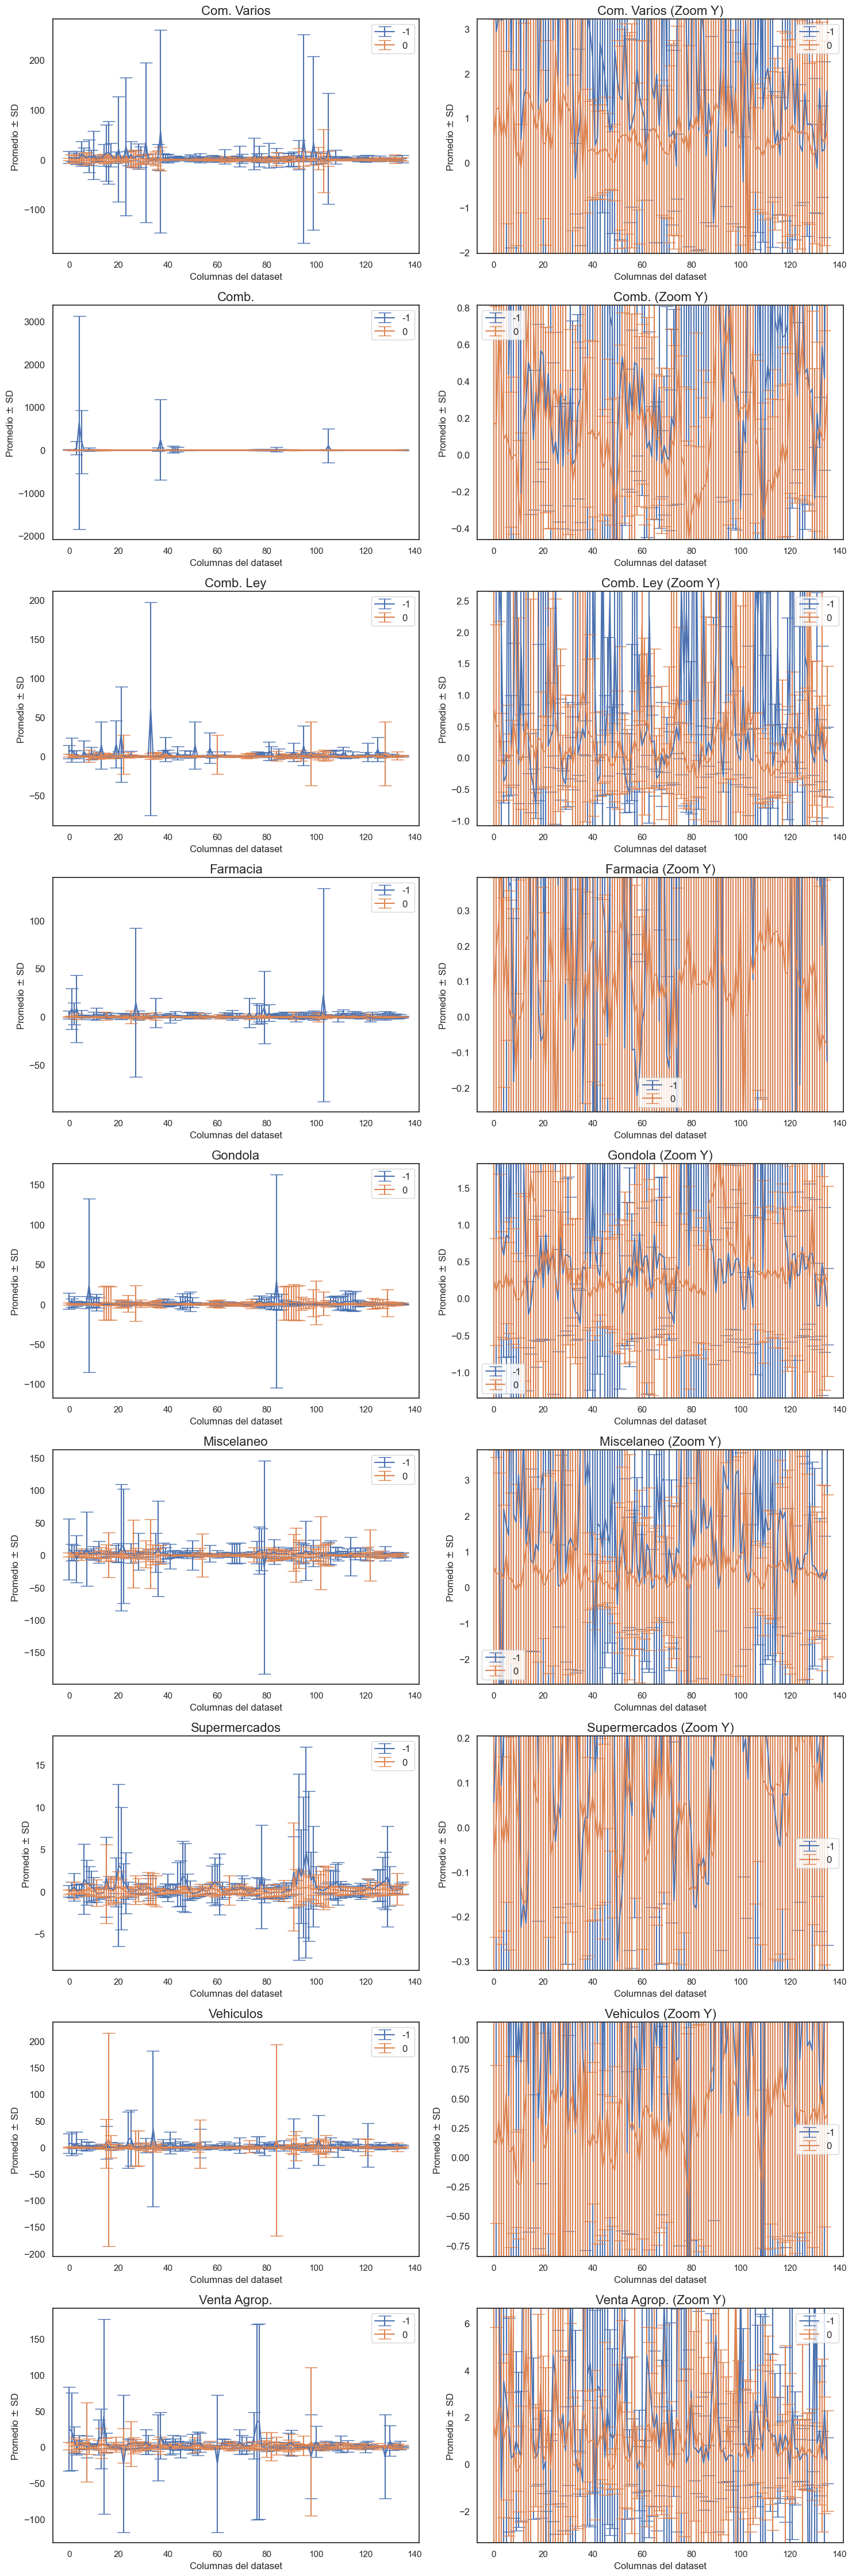

In [165]:
subrubros = final.Subrubro.unique()

num_subplots = len(subrubros)

fig, axs = plt.subplots(num_subplots, 2, figsize=(15, 5 * num_subplots))

for i, sr in enumerate(subrubros):

    menos_uno = final[(final['Subrubro'] == sr) & (final['Cluster'] == -1)][F_Ven + F_Com + Y_Ven + Y_Com].copy()
    cero = final[(final['Subrubro'] == sr) & (final['Cluster'] == 0)][F_Ven + F_Com + Y_Ven + Y_Com].copy()

    axs[i, 0].errorbar(range(len(menos_uno.mean())), menos_uno.mean(), yerr=menos_uno.std(), capsize=8, label='-1')
    axs[i, 0].errorbar(range(len(cero.mean())), cero.mean(), yerr=cero.std(), capsize=8, label='0')

    axs[i, 0].set_title(sr, fontsize=16)
    axs[i, 0].set_ylabel(r'Promedio $\pm$ SD', fontsize=12)
    axs[i, 0].tick_params(axis='y', labelsize=12)
    axs[i, 0].legend(fontsize=12)
    axs[i, 0].set_xlabel('Columnas del dataset', fontsize=12)

    y_mean = cero.mean()
    y_std = cero.std()
    y_min = (y_mean - y_std).iloc[0]
    y_max = (y_mean + y_std).iloc[0]

    axs[i, 1].errorbar(range(len(menos_uno.mean())), menos_uno.mean(), yerr=menos_uno.std(), capsize=8, label='-1')
    axs[i, 1].errorbar(range(len(cero.mean())), cero.mean(), yerr=cero.std(), capsize=8, label='0')

    axs[i, 1].set_title(sr + ' (Zoom Y)', fontsize=16)
    axs[i, 1].set_ylabel(r'Promedio $\pm$ SD', fontsize=12)
    axs[i, 1].tick_params(axis='y', labelsize=12)
    axs[i, 1].legend(fontsize=12)
    axs[i, 1].set_xlabel('Columnas del dataset', fontsize=12)
    
    axs[i, 1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

En números:

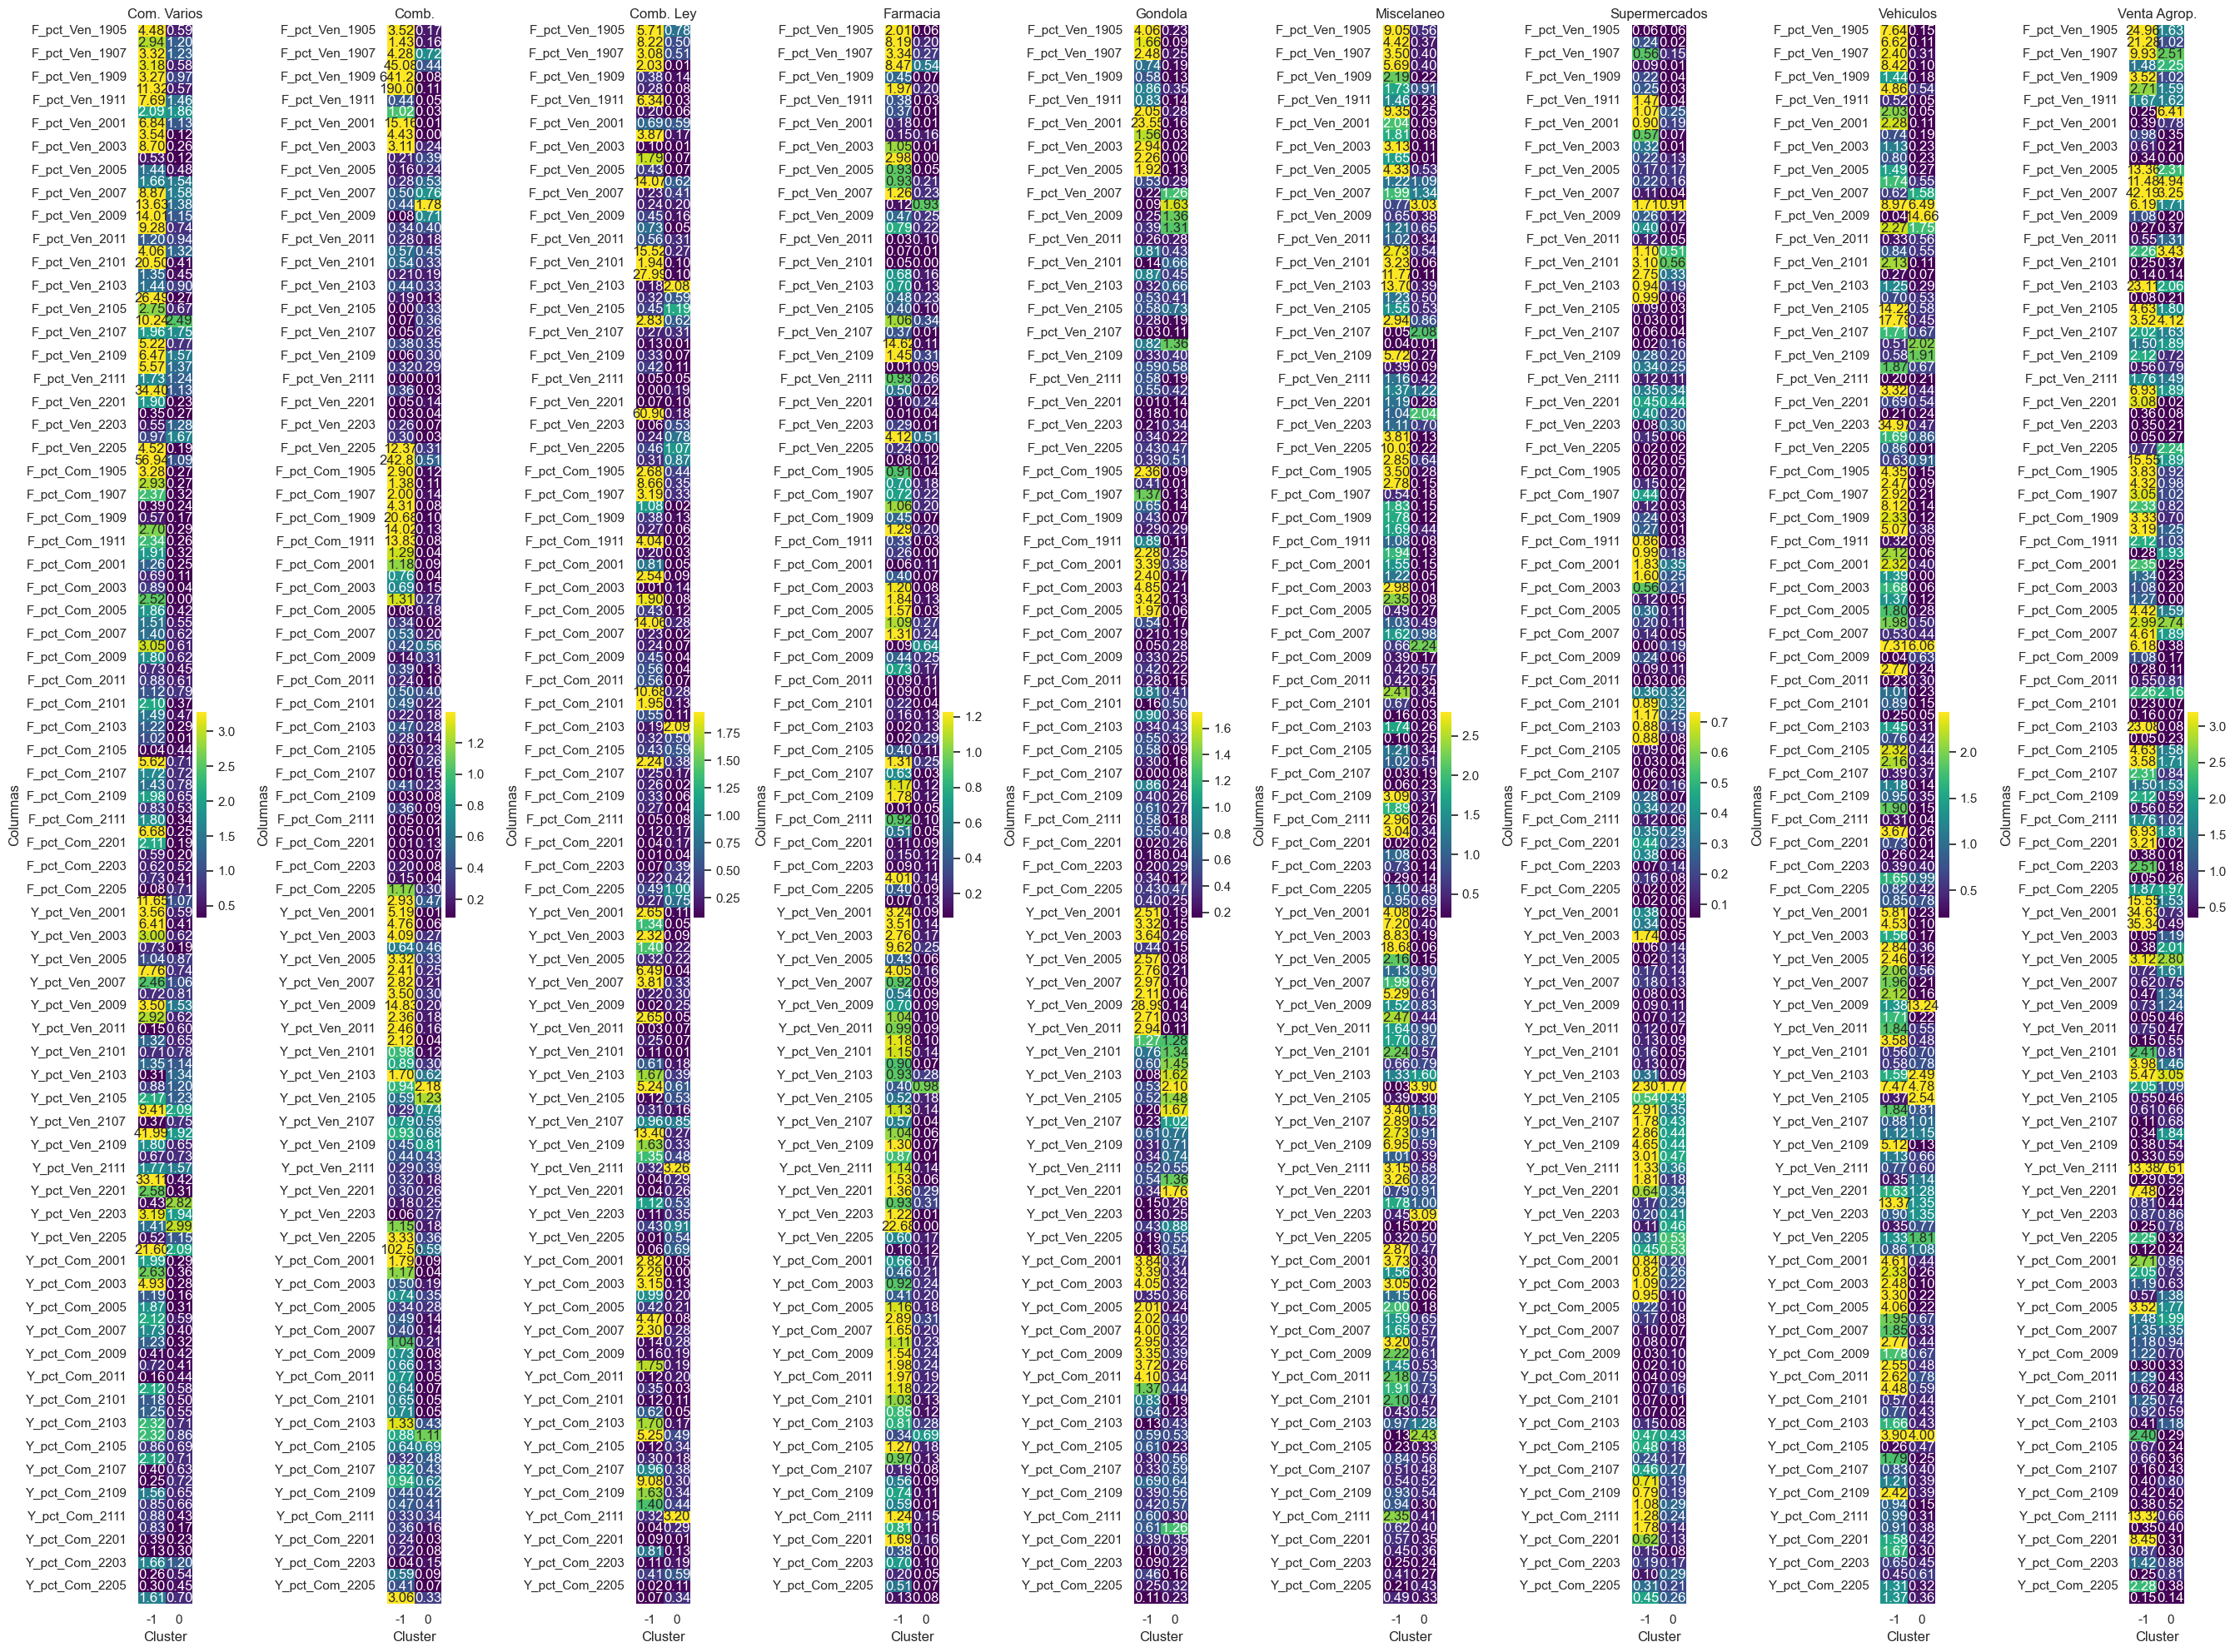

In [215]:
subrubros = final['Subrubro'].unique()
num_columns = len(subrubros)

fig, axes = plt.subplots(1, num_columns, figsize=(3*num_columns, 20))

for i, subrubro in enumerate(subrubros):
    data_subset = final[final['Subrubro'] == subrubro]
    media_por_cluster = data_subset.groupby('Cluster')[F_Ven + F_Com + Y_Ven + Y_Com].mean().reset_index()
    media_por_cluster_transpuesto = media_por_cluster.set_index('Cluster').T
    media_por_cluster_transpuesto[-1] = media_por_cluster_transpuesto[-1].abs()
    media_por_cluster_transpuesto[0] = media_por_cluster_transpuesto[0].abs()
    vmin = min(np.percentile(media_por_cluster_transpuesto[-1], 25), np.percentile(media_por_cluster_transpuesto[0], 25))
    vmax = max(np.percentile(media_por_cluster_transpuesto[-1], 75), np.percentile(media_por_cluster_transpuesto[0], 75))
    sns.heatmap(
        media_por_cluster_transpuesto,
        cmap='viridis',
        annot=True,
        fmt=".2f",
        cbar=True,
        vmin=vmin,
        vmax=vmax,
        ax=axes[i]
    )
    axes[i].set_title(f'{subrubro}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Columnas')

plt.tight_layout()
plt.show()

## Evaluación con clases

### Homogeneidad: cada cluster contiene sólo miembros de una clase

### Completitud: todos los miembros de una clase están en el mismo cluster

### V-measure: media armónica de los anteriores

### Adjusted Rand index: semejanza entre las etiquetas originales y las asignadas

### Información Mutua entre etiquetas originales y asignadas